# JAFFE Model

# Pre-processing

Import the JAFFE dataset and extract dominant labels. The image name consists of two parts, the name of model and the dominanat label, eg: KM is the name of model with neutral as dominant feature

In [1]:
#set this to true to train new models, setting this variable to True will make the code excute in a longer time and its
#unncessary for the project to run correctly as a keras model is already saved in saved_models/best_model.h5
train_flag = False

In [2]:
from PIL import Image
import glob
from matplotlib import pyplot as plt
import numpy as np

raw_images = []
raw_labels = []
for filename in glob.glob('jaffe\images/*.tiff'):
    raw_labels.append(filename[16:18])
    im = Image.open(filename)
    raw_images.append(im)
#make sure images are uploaded correctly
print(len(raw_images))
imgplot = plt.imshow(raw_images[0])
#plot the number of each label
num_neutral = raw_labels.count('NE')
num_happy = raw_labels.count('HA')
num_sad = raw_labels.count('SA')
num_surprised = raw_labels.count('SU')
num_angry = raw_labels.count('AN')
num_disgust = raw_labels.count('DI')
num_fear = raw_labels.count('FE')
print("The number of labels are as follows")
print("Neutral : {}  Happy : {}  Sad : {}  Surprised : {}  Angry : {}  Disgust : {}  Fear : {}"\
      .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

213
The number of labels are as follows
Neutral : 30  Happy : 31  Sad : 31  Surprised : 30  Angry : 30  Disgust : 29  Fear : 32


### Train_Test Split

DI


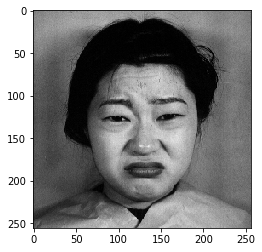

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(raw_images, raw_labels, test_size = 0.25, random_state = 42, shuffle = True)
plt.imshow(X_train[0], cmap = plt.cm.gray)
print(Y_train[0])

### Augmentation

Add random gaussian noise, random rotation and random skewness to the images. Translation wont be used in this project since the image will be cropped to just the face.

C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


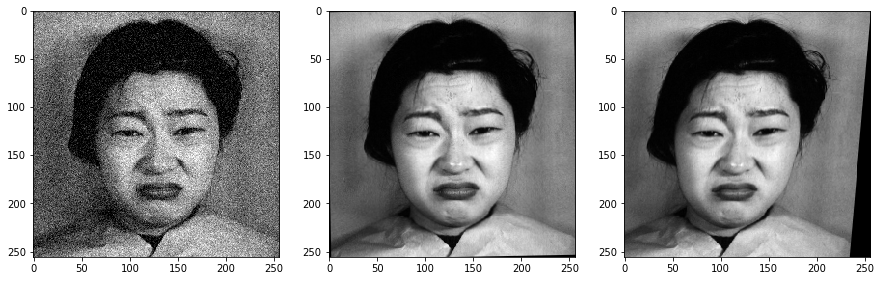

In [4]:
from preprocessing import random_noise, random_rotation, random_skew

plt.figure(1, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(random_noise(X_train[0]), cmap = plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(random_rotation(X_train[0]), cmap = plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(random_skew(X_train[0]), cmap = plt.cm.gray)

Apply the transformation functions to the dataset to obtain a dataset of 1000 images

In [5]:
from preprocessing import augment
#augment training dataset
augmented_train_iamges, augmented_train_labels = augment(X_train, Y_train, desired_size = 500)
print("train dataset size is: {} images".format(len(augmented_train_iamges)))

#augment testing dataset
X_test, Y_test = augment(X_test, Y_test, desired_size = 100)
print("test dataset size is: {} images".format(len(X_test)))

C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


train dataset size is: 500 images
test dataset size is: 100 images


In [6]:
from preprocessing import JAFFE_count
#print number of labels in training dataset
num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear = JAFFE_count(augmented_train_labels)
print("The training dataset contains {} neutral, {} happy, {} sad, {} surprised, {} angry, {} disgust, {} fear images"
     .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

#print the number of labels in testing dataset
num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear = JAFFE_count(Y_test)
print("The testing dataset contains {} neutral, {} happy, {} sad, {} surprised, {} angry, {} disgust, {} fear images"
     .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

The training dataset contains 63 neutral, 62 happy, 74 sad, 59 surprised, 78 angry, 86 disgust, 78 fear images
The testing dataset contains 20 neutral, 15 happy, 8 sad, 16 surprised, 15 angry, 7 disgust, 19 fear images


### Encoding Labels
Transform the labels into a vector of seven numbers [Neutral Happy Sad Surprised Angry Disgust Fear] where an entry of 1 describes the label of the image

[0 1 0 0 0 0 0] descrbies a happy image

In [7]:
from preprocessing import JAFFE_encode
augmented_train_labels = JAFFE_encode(augmented_train_labels)
print(len(augmented_train_labels))
print(augmented_train_labels[0])

Y_test = JAFFE_encode(Y_test)
print(len(Y_test))
print(Y_test[0])

500
[0. 0. 0. 0. 0. 1. 0.]
100
[0. 0. 0. 0. 0. 0. 1.]


### Face detection

Number of faces detected: 1


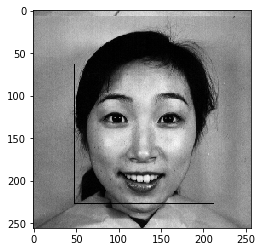

In [8]:
import cv2 
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
img = np.array(augmented_train_iamges[50])
faces = face_cascade.detectMultiScale(img)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),0)
plt.imshow(img, cmap = plt.cm.gray)


### Cropping
before cropping we want to remove images that have zero detected faces or more than one detected face. also remove images that have too small detected faces (some images have detected faces that are not actually faces and are too small regions)

In [9]:
from preprocessing import crop_face
#crop training images
train_images, train_labels = crop_face(augmented_train_iamges, augmented_train_labels)
print("\rfinal train dataset size after removing images with undetectable faces = {}".format(len(train_images)))

#crop testing images
test_images, test_labels = crop_face(X_test, Y_test)
print("\rfinal test dataset size after removing images with undetectable faces = {}".format(len(test_images)))

final train dataset size after removing images with undetectable faces = 499
final test dataset size after removing images with undetectable faces = 100


[0. 0. 1. 0. 0. 0. 0.]


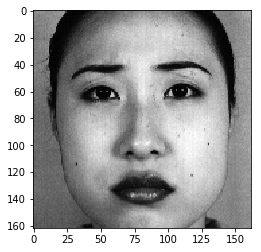

In [10]:
plt.imshow(train_images[20], cmap = plt.cm.gray)
print(train_labels[20])

In [11]:
#resize all images to largest cropped image size
from preprocessing import resize
final_size = 197 #final size of images
train_images = resize(train_images, final_size)
test_images = resize(test_images, final_size)
print("The final image dataset has a dimensions of {}".format(train_images[0].size))

The final image dataset has a dimensions of (197, 197)


### Normalization

In [12]:
from preprocessing import normalize

norm_train_images = [normalize(train_images[i]) for i in range(len(train_images))]
print(norm_train_images[0])

norm_test_images = [normalize(test_images[i]) for i in range(len(test_images))]

[[0.45374449 0.39647577 0.34801762 ... 0.19823789 0.19823789 0.1938326 ]
 [0.4185022  0.35242291 0.2907489  ... 0.14096916 0.22907489 0.21585903]
 [0.37004405 0.38325991 0.26431718 ... 0.07929515 0.15418502 0.17180617]
 ...
 [0.25550661 0.25550661 0.24669604 ... 0.59030837 0.56387665 0.54185022]
 [0.23788546 0.24229075 0.24669604 ... 0.59911894 0.58590308 0.57709251]
 [0.23348018 0.21145374 0.22907489 ... 0.60792952 0.6123348  0.59030837]]


### Convert to 4D tensors

In [13]:
def convert_to_tensors(image_array, n_channels):
    image_array = np.array(image_array)
    tensors = np.resize(image_array, (image_array.shape[0], image_array.shape[1], image_array.shape[2], n_channels))
    return tensors

In [14]:

X_train_jaffe = convert_to_tensors(norm_train_images, 1)
X_test_jaffe = convert_to_tensors(norm_test_images, 1)
Y_train_jaffe = train_labels
Y_test_jaffe = test_labels
print(X_train_jaffe.shape)
print(X_test_jaffe.shape)

(499, 197, 197, 1)
(100, 197, 197, 1)


# Training

### Initialize  Hyperparameters Grid

In [15]:

parameters_grid = {
    'initial_n_filters' : [16, 32, 64],
    'kernel_size' : [2, 3, 4, 5, 6, 7]
}

### Creating Model

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

def create_model(parameters):
    model = Sequential()

    model.add(Conv2D(name = "conv1", filters= parameters['initial_n_filters'], kernel_size = parameters['kernel_size'], 
                     strides=1,kernel_initializer = 'random_normal', padding='same', 
                        activation='relu', input_shape=(X_train_jaffe.shape[1], X_train_jaffe.shape[2], 1)))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(name = "conv2", filters= parameters['initial_n_filters']*2, kernel_size = parameters['kernel_size'], 
                     strides=1,kernel_initializer = 'random_normal', padding='same', activation='relu')) 
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(name = "conv3", filters=random_parameters['initial_n_filters']*4, kernel_size = random_parameters['kernel_size'], 
                     strides=1,kernel_initializer = 'random_normal', padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

Using TensorFlow backend.


### Create optimizer

In [17]:
def create_RMSprop_optimizer(parameters):
    return RMSprop()

###  Compile and Train Model

In [18]:
import random
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, History


if(train_flag == True):
    #select how many random hyperparameters selection iterations
    n_iterations = 10
    #initlaize global min_val_loss
    global_min_val_loss = np.inf
    for i in range(n_iterations):
        print('\r{}/{}'. format(i, n_iterations))
        #initilaize random hyperparameters
        random_parameters = {K: random.sample(V, 1)[0] for K, V in parameters_grid.items()}
        #create model with random hyperparameters
        model = create_model(random_parameters)
        opt = create_RMSprop_optimizer(random_parameters)
        #compile model
        model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
        #train model
        epochs = 1000
        checkpointer = ModelCheckpoint(filepath='saved_models/model_weights.hdf5', verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
        history = model.fit(X_train_jaffe, Y_train_jaffe,
                  callbacks = [checkpointer, early_stopping],
                  validation_split = 0.33,
                  epochs=epochs, batch_size = 20, verbose=1)
        #compare current min validation loss with global min validation loss
        current_min_val_loss = np.min(history.history['val_loss'])
        if(current_min_val_loss < global_min_val_loss):
            global_min_val_loss = current_min_val_loss
            #save the best model so far
            model.load_weights('saved_models/model_weights.hdf5')
            model.save('saved_models/best_model.h5')
            print('saving new best model, val_loss = {}'.format(current_min_val_loss))
            #save best hyperparameters
            best_hyperparameters = random_parameters




### Load best model

In [19]:
from keras.models import load_model
best_model = load_model('saved_models/best_model.h5')

## Test model

In [20]:
label_dic = {
    0 : 'Neutral',
    1 : 'Happy',
    2 : 'Sad',
    3 : 'Surprised',
    4 : 'Angry',
    5 : 'Disgusted',
    6 : 'Fear'
}
def predictions_to_labels(predictions, label_dic):
    predictions = np.argmax(predictions, axis = 1)
    return [label_dic[predictions[i]] for i in range(len(predictions))]

In [21]:
predicitons = [np.argmax(best_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test_jaffe]
#calculate accuracy

targets = np.argmax(Y_test_jaffe, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 84.0000%


### Confusion Matrix

In [66]:
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = [0, 1, 2, 3, 4, 5, 6]

print(pd.DataFrame(confusion_matrix(targets, predicitons, labels),
                   index = ['Neutral', 'Happy', 'Sad', 'Surprised', 'Angry', 'Disgust', 'Fear'],
                  columns = ['Neutral', 'Happy', 'Sad', 'Surprised', 'Angry', 'Disgust', 'Fear']))

           Neutral  Happy  Sad  Surprised  Angry  Disgust  Fear
Neutral          0      9    0         13      0        7     1
Happy            0      4    0         15      0       10     0
Sad              0      7    0         11      0       12     1
Surprised        0      5    0         17      0        8     1
Angry            0      5    0         11      0       15     0
Disgust          0      7    0          9      0       12     2
Fear             0      0    0          0      0        0     0


### Model summary

In [23]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 197, 197, 64)      1664      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 98, 98, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 98, 98, 128)       204928    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 49, 49, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 49, 49, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 49, 49, 256)       819456    
__________

In [65]:
best_model.get_config()

[{'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 197, 197, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 64,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'RandomNormal',
    'config': {'mean': 0.0, 'seed': None, 'stddev': 0.05}},
   'kernel_regularizer': None,
   'kernel_size': (5, 5),
   'name': 'conv1',
   'padding': 'same',
   'strides': (1, 1),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'MaxPooling2D',
  'config': {'data_format': 'channels_last',
   'name': 'max_pooling2d_13',
   'padding': 'valid',
   'pool_size': (2, 2),
   'strides': (2, 2),
   'trainable': True}},
 {'class_name': 'Dropout',
  'config': {'name': 'dropout_13',
   'noise_shape': None,
   'rate': 0.2,
   'seed': None,
   'tr

### Transfer learning

In order to use ResNet50 the iamges has to be atleast 197x197 RGB images, to overcome this the grayscale images will be transfered into RGB images where eaach channel has exactly the same numbers.

(197, 197, 3)
(197, 197, 3)


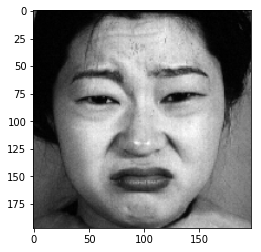

In [24]:
X_train = resize(norm_train_images, 197)
X_test = resize(norm_test_images, 197)
X_train = [cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2RGB) for img in X_train]
X_test = [cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2RGB) for img in X_test]

print(X_train[0].shape)
print(X_test[0].shape)
plt.imshow(X_train[0])

In [25]:
# Conver to 4D tensors
X_train = convert_to_tensors(X_train, 3)
X_test = convert_to_tensors(X_test, 3)
print(X_train.shape)

(499, 197, 197, 3)


In [26]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = Sequential()

ResNet50_model.add(ResNet50(include_top = False, weights = 'imagenet', input_shape=(X_train.shape[1], X_train.shape[2], 3)))
ResNet50_model.add(GlobalAveragePooling2D())
ResNet50_model.add(Dense(7, activation = 'softmax'))
ResNet50_model.layers[0].trainable = False


C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [27]:
ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
ResNet50_model.compile(optimizer = 'RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNet50_model.fit(X_train, Y_train_jaffe, 
            validation_split = 0.33,
            epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 334 samples, validate on 165 samples
Epoch 1/20
334/334 [==============================] - 6s 17ms/step - loss: 1.9789 - acc: 0.2186 - val_loss: 2.2618 - val_acc: 0.1758

Epoch 00001: val_loss improved from inf to 2.26177, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 2/20
334/334 [==============================] - 2s 7ms/step - loss: 1.5049 - acc: 0.4701 - val_loss: 2.3623 - val_acc: 0.1758

Epoch 00002: val_loss did not improve from 2.26177
Epoch 3/20
334/334 [==============================] - 3s 8ms/step - loss: 1.2720 - acc: 0.5719 - val_loss: 2.5608 - val_acc: 0.1758

Epoch 00003: val_loss did not improve from 2.26177
Epoch 4/20
334/334 [==============================] - 2s 7ms/step - loss: 1.1170 - acc: 0.6377 - val_loss: 2.6170 - val_acc: 0.1758

Epoch 00004: val_loss did not improve from 2.26177
Epoch 5/20
334/334 [==============================] - 2s 7ms/step - loss: 0.9285 - acc: 0.7635 - val_loss: 2.6441 - val_acc: 0.1758

Epoch 00005: val_loss did n

In [30]:
ResNet_predicitons = [np.argmax(ResNet50_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test]
#calculate accuracy
targets = np.argmax(Y_test, axis = 1)
test_accuracy = (100* np.sum(ResNet_predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 15.0000%


# Cohn-Kanade Model


# Pre-processing

Import the cohn-kanade dataset, the cohn-kanade dataset consists of a sequence of frames for each subject for each emotion where the last frame shows the extreme features of that emotion. The frames start at neutral condition and starts to develop into the label emotion. unfortunately not all the images are labeled, The code below is used to import the cohn-kanade dataset and the labels excluding frames that contain neutral reactions. 

In [95]:
import glob

from keras.utils.np_utils import to_categorical
import pathlib
from PIL import Image
from preprocessing import cohn_rearrange

images = []
cohn_labels = []
for file in glob.glob('cohn-kanade/cohn-kanade-labels/*/**/*.txt'):
    label = float(open(file, 'r').read()) - 2
    image_path = file.replace("_emotion.txt", ".png").replace("cohn-kanade/cohn-kanade-labels",
                                                          "cohn-kanade/cohn-kanade-images")
    image_path_data = image_path.split("_")
    final_frame_index = int(image_path_data[-1].replace(".png", ""))
    for index in range(final_frame_index // 2, final_frame_index + 1):
        dir = '_'.join(image_path_data[:-1] + ['%08d' % index + '.png'])
        if pathlib.Path(dir).is_file():
            images.append(dir)
            cohn_labels.append(label)

cohn_labels = to_categorical(cohn_labels, len(set(cohn_labels)))
cohn_labels = cohn_rearrange(cohn_labels)
label_titles = ["Angry", "Disgust", "Fear", "Happy", "Sadness", "Surprise", "Contempt"]
cohn_images = []
for path in images:
    im = Image.open(path)
    cohn_images.append(im)
    


### Train-Test split

In [96]:
from sklearn.model_selection import train_test_split
from preprocessing import cohn_count

X_train, X_test, Y_train, Y_test = train_test_split(cohn_images, cohn_labels, test_size = 0.25,
                                                    random_state = 42, shuffle = True)
print("\rThe Train dataset consists of {} images".format(len(X_train)))
num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt = cohn_count(Y_train)
print("num_angry = {}, num_happy = {}, num_sad = {}, num_surprised = {}, num_disgust = {}, num_fear = {}, num_contempt = {}"
     .format(num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt))

print("The Test dataset consists of {} images".format(len(X_test)))
num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt = cohn_count(Y_test)
print("num_angry = {}, num_happy = {}, num_sad = {}, num_surprised = {}, num_disgust = {}, num_fear = {}, num_contempt = {}"
     .format(num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt))

The Train dataset consists of 2508 images
num_angry = 432, num_happy = 554, num_sad = 230, num_surprised = 574, num_disgust = 378, num_fear = 234, num_contempt = 106
The Test dataset consists of 836 images
num_angry = 134, num_happy = 201, num_sad = 76, num_surprised = 191, num_disgust = 129, num_fear = 69, num_contempt = 36


### Augmentation


In [97]:
from preprocessing import cohn_augment
#augment training dataset
X_train, Y_train = cohn_augment(X_train, Y_train, desired_size = 5000)
#augment testing dataset
X_test, Y_test = cohn_augment(X_test, Y_test, desired_size = 1000)

print("\nThe Train dataset consists of {} images".format(len(X_train)))
num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt = cohn_count(Y_train)
print("num_angry = {}, num_happy = {}, num_sad = {}, num_surprised = {}, num_disgust = {}, num_fear = {}, num_contempt = {}"
     .format(num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt))

print("The Test dataset consists of {} images".format(len(X_test)))
num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt = cohn_count(Y_test)
print("num_angry = {}, num_happy = {}, num_sad = {}, num_surprised = {}, num_disgust = {}, num_fear = {}, num_contempt = {}"
     .format(num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt))


6/2492

C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


163/16492
The Train dataset consists of 5000 images
num_angry = 886, num_happy = 1132, num_sad = 444, num_surprised = 1129, num_disgust = 738, num_fear = 462, num_contempt = 209
The Test dataset consists of 1000 images
num_angry = 156, num_happy = 243, num_sad = 94, num_surprised = 223, num_disgust = 156, num_fear = 84, num_contempt = 44


### Face detection

Number of faces detected: 1


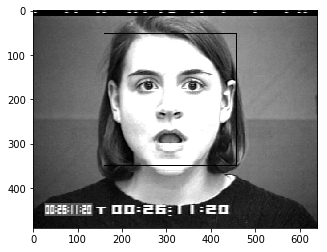

In [98]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
img = np.array(X_train[2])
faces = face_cascade.detectMultiScale(img)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),0)
plt.imshow(img, cmap = plt.cm.gray)

### Convert RGB images to grayscale

some of the images are RGB images to avoid dimension conflicts all images are to be changed to grayscale

In [99]:
X_train = [np.array(img) for img in X_train]
for i,img in enumerate(X_train):
    if len(img.shape) > 2:
        X_train[i] = img[:,:,0]
X_test = [np.array(img) for img in X_test]
for i,img in enumerate(X_test):
    if len(img.shape) > 2:
        X_test[i] = img[:,:,0]

### Cropping

In [100]:
from preprocessing import crop_face
#crop training images
train_images, train_labels = crop_face(X_train, Y_train)
print("\rfinal train dataset size after removing images with undetectable faces = {}".format(len(train_images)))

#crop testing images
test_images, test_labels = crop_face(X_test, Y_test)
print("\rfinal test dataset size after removing images with undetectable faces = {}".format(len(test_images)))

final train dataset size after removing images with undetectable faces = 4975
final test dataset size after removing images with undetectable faces = 994


In [101]:
#resize all images to largest cropped image size
from preprocessing import resize
final_size = 197 #final size of images
train_images = resize(train_images, final_size)
test_images = resize(test_images, final_size)
print("The final image dataset has a dimensions of {}".format(train_images[0].size))

The final image dataset has a dimensions of (197, 197)


[0. 1. 0. 0. 0. 0. 0.]


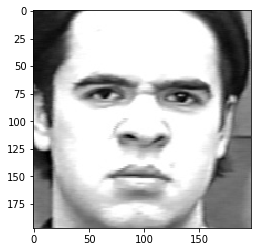

In [102]:
plt.imshow(train_images[10], cmap = plt.cm.gray)
print(train_labels[10])

### Normalization

In [103]:
from preprocessing import normalize

norm_train_images = [normalize(train_images[i]) for i in range(len(train_images))]
print(norm_train_images[0])

norm_test_images = [normalize(test_images[i]) for i in range(len(test_images))]

[[0.37254902 0.37254902 0.37254902 ... 0.48235294 0.47843137 0.48235294]
 [0.37647059 0.37647059 0.37647059 ... 0.48627451 0.49019608 0.49019608]
 [0.37254902 0.37647059 0.38039216 ... 0.48627451 0.49019608 0.48627451]
 ...
 [0.2627451  0.2627451  0.2627451  ... 0.35686275 0.34901961 0.34901961]
 [0.2627451  0.2627451  0.2627451  ... 0.35686275 0.35294118 0.35686275]
 [0.25490196 0.25882353 0.2627451  ... 0.35294118 0.34901961 0.35686275]]


### Convert to 4D tensors

In [104]:
X_train = convert_to_tensors(norm_train_images, 1)
X_test = convert_to_tensors(norm_test_images, 1)
Y_train = train_labels
Y_test = test_labels
print(X_train.shape)
print(X_test.shape)

(4975, 197, 197, 1)
(994, 197, 197, 1)


# Training

Train to model created above on the cohn-kanade dataset

In [78]:
import random
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, History


if(train_flag == True):
    #select how many random hyperparameters selection iterations
    n_iterations = 5
    #initlaize global min_val_loss
    global_min_val_loss = np.inf
    for i in range(n_iterations):
        print('\r{}/{}'. format(i, n_iterations))
        #initilaize random hyperparameters
        random_parameters = {K: random.sample(V, 1)[0] for K, V in parameters_grid.items()}
        #create model with random hyperparameters
        model = create_model(random_parameters)
        opt = create_RMSprop_optimizer(random_parameters)
        #compile model
        model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
        #train model
        epochs = 1000
        checkpointer = ModelCheckpoint(filepath='saved_models/model_weights.hdf5', verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
        history = model.fit(X_train, Y_train,
                  callbacks = [checkpointer, early_stopping],
                  validation_split = 0.33,
                  epochs=epochs, batch_size = 20, verbose=1)
        #compare current min validation loss with global min validation loss
        current_min_val_loss = np.min(history.history['val_loss'])
        if(current_min_val_loss < global_min_val_loss):
            global_min_val_loss = current_min_val_loss
            #save the best model so far
            model.load_weights('saved_models/model_weights.hdf5')
            model.save('saved_models/cohn_model.h5')
            print('saving new best model, val_loss = {}'.format(current_min_val_loss))
            #save best hyperparameters
            best_hyperparameters = random_parameters

### Load best Cohn-kanade Model

In [91]:
from keras.models import load_model
cohn_model = load_model('saved_models/cohn_model.h5')
cohn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 197, 197, 32)      1600      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 98, 98, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 98, 98, 64)        100416    
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 49, 49, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 49, 49, 128)       401536    
__________

In [64]:
cohn_model.get_config()

[{'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 197, 197, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 32,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'RandomNormal',
    'config': {'mean': 0.0, 'seed': None, 'stddev': 0.05}},
   'kernel_regularizer': None,
   'kernel_size': (7, 7),
   'name': 'conv1',
   'padding': 'same',
   'strides': (1, 1),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'MaxPooling2D',
  'config': {'data_format': 'channels_last',
   'name': 'max_pooling2d_38',
   'padding': 'valid',
   'pool_size': (2, 2),
   'strides': (2, 2),
   'trainable': True}},
 {'class_name': 'Dropout',
  'config': {'name': 'dropout_37',
   'noise_shape': None,
   'rate': 0.2,
   'seed': None,
   'tr

## Test the Model

In [107]:
predicitons = [np.argmax(cohn_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test]
#calculate accuracy
targets = np.argmax(Y_test, axis = 1)
print(targets[0])
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

1
Test accuracy = 99.6982%


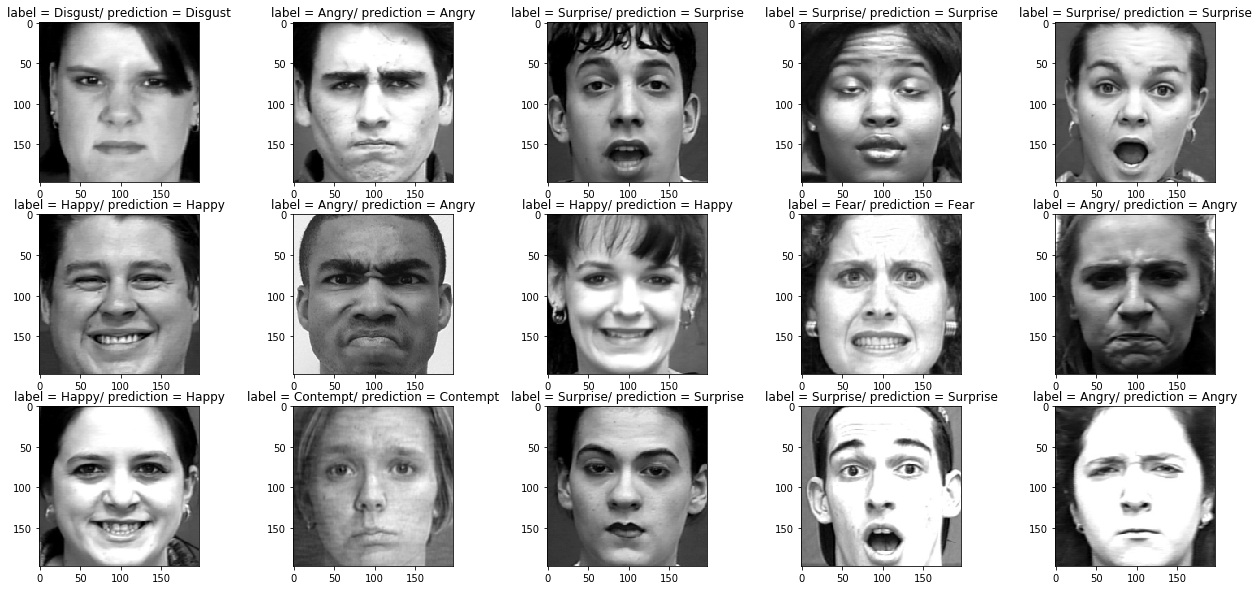

In [111]:
fig = plt.figure(figsize = (22,10))
for i in range(15):
    ax = fig.add_subplot(3,5,i+1)
    ax.imshow(X_test[i,:,:,0], cmap = plt.cm.gray)
    ax.set_title('label = {}/ prediction = {}'.format(label_titles[targets[i]], label_titles[predicitons[i]]))

## Confusion Matrix

In [44]:
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = [0, 1, 2, 3, 4, 5, 6]

print(pd.DataFrame(confusion_matrix(targets, predicitons, labels),
                   index = label_titles,
                  columns = label_titles))

          Angry  Disgust  Fear  Happy  Sadness  Surprise  Contempt
Angry       161        0     0      0        0         0         0
Disgust       0      162     1      1        0         0         0
Fear          1        0    80      0        0         0         0
Happy         0        0     0    237        0         0         0
Sadness       0        0     0      0       92         0         0
Surprise      0        0     0      0        0       217         1
Contempt      0        0     0      0        0         0        42


## Test Cohn model on the Jaffe images

In [112]:
jaffe_images = raw_images
jaffe_labels = raw_labels

In [113]:
from preprocessing import JAFFE_encode

encoded_jaffe_labels = JAFFE_encode(jaffe_labels)
print(len(encoded_jaffe_labels))
print(encoded_jaffe_labels[0])

213
[0. 0. 0. 0. 1. 0. 0.]


First we have to remove the neutral images from the jaffe dataset because the cohn model doesnt predict neutral images

In [114]:
from preprocessing import remove_neutral

jaffe_images, jaffe_labels = remove_neutral(jaffe_images, encoded_jaffe_labels)

reorder the jaffe label vector to match the cohn labels vector

In [115]:
from preprocessing import jaffe_reorder

jaffe_labels = jaffe_reorder(jaffe_labels)

In [116]:
jaffe_labels = [np.array(label) for label in jaffe_labels]

In [117]:
from preprocessing import crop_face
#crop training images
jaffe_images, jaffe_labels = crop_face(jaffe_images, jaffe_labels)




180/183

In [118]:
from preprocessing import resize
final_size = 197 #final size of images
jaffe_images = resize(jaffe_images, final_size)


In [119]:
from preprocessing import normalize

jaffe_images = [normalize(jaffe_images[i]) for i in range(len(jaffe_images))]


In [120]:
jaffe_images = convert_to_tensors(jaffe_images, 1)
print(jaffe_images.shape)


(182, 197, 197, 1)


In [121]:
predicitons = [np.argmax(cohn_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in jaffe_images]
#calculate accuracy
targets = np.argmax(jaffe_labels, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 35.7143%


In [122]:
labels = [0, 1, 2, 3, 4, 5, 6]

print(pd.DataFrame(confusion_matrix(targets, predicitons, labels),
                   index = label_titles,
                  columns = label_titles))

          Angry  Disgust  Fear  Happy  Sadness  Surprise  Contempt
Angry         9        0     5      7        0         9         0
Disgust       8        0    12      7        0         2         0
Fear          5        0    14      1        0        11         0
Happy         6        0     2     15        0         8         0
Sadness      14        1     2      3        0        11         0
Surprise      3        0     0      0        0        27         0
Contempt      0        0     0      0        0         0         0


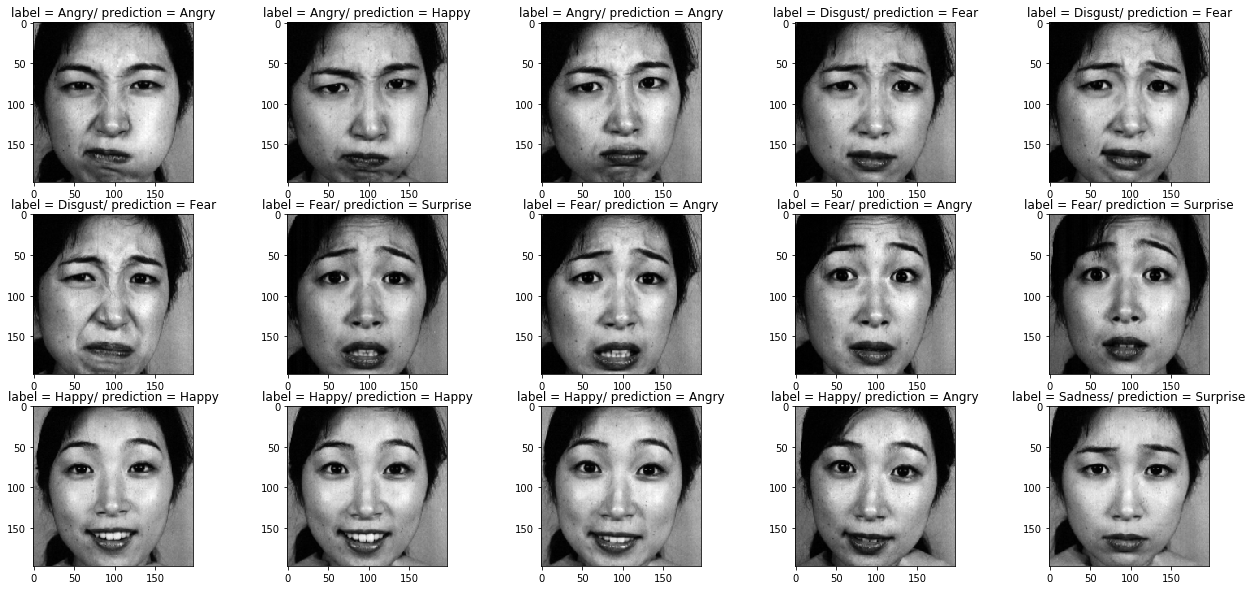

In [123]:
fig = plt.figure(figsize = (22,10))
for i in range(15):
    ax = fig.add_subplot(3,5,i+1)
    ax.imshow(jaffe_images[i,:,:,0], cmap = plt.cm.gray)
    ax.set_title('label = {}/ prediction = {}'.format(label_titles[targets[i]], label_titles[predicitons[i]]))

## Transfer learning

(197, 197, 3)
(197, 197, 3)


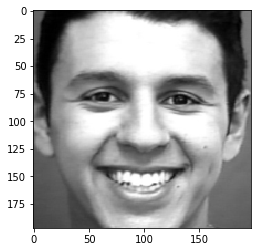

In [56]:
X_train = resize(norm_train_images, 197)
X_test = resize(norm_test_images, 197)
X_train = [cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2RGB) for img in X_train]
X_test = [cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2RGB) for img in X_test]

print(X_train[0].shape)
print(X_test[0].shape)
plt.imshow(X_train[0])

In [57]:
# Conver to 4D tensors
X_train = convert_to_tensors(X_train, 3)
X_test = convert_to_tensors(X_test, 3)
print(X_train.shape)

(4966, 197, 197, 3)


In [58]:
from keras import applications

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(197, 197,3))
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(7, 
                    activation='softmax'))
inception_model = add_model
inception_model.compile(optimizer = 'RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 14343     
Total params: 21,817,127
Trainable params: 14,343
Non-trainable params: 21,802,784
_________________________________________________________________


In [59]:
checkpointer = ModelCheckpoint('saved_models/weights.best.cohn.inception.hdf5', verbose=1, save_best_only=True)

history = inception_model.fit(X_train, train_labels,
                  callbacks = [checkpointer],
                  validation_split = 0.33,
                  epochs=20, batch_size = 40, verbose=1)


Train on 3327 samples, validate on 1639 samples
Epoch 1/20
3327/3327 [==============================] - 21s 6ms/step - loss: 1.6627 - acc: 0.3904 - val_loss: 2.3399 - val_acc: 0.2209

Epoch 00001: val_loss improved from inf to 2.33992, saving model to saved_models/weights.best.cohn.inception.hdf5
Epoch 2/20
3327/3327 [==============================] - 13s 4ms/step - loss: 1.2669 - acc: 0.5648 - val_loss: 2.1319 - val_acc: 0.2855

Epoch 00002: val_loss improved from 2.33992 to 2.13188, saving model to saved_models/weights.best.cohn.inception.hdf5
Epoch 3/20
3327/3327 [==============================] - 13s 4ms/step - loss: 1.0792 - acc: 0.6264 - val_loss: 2.2180 - val_acc: 0.2441

Epoch 00003: val_loss did not improve from 2.13188
Epoch 4/20
3327/3327 [==============================] - 13s 4ms/step - loss: 0.9776 - acc: 0.6736 - val_loss: 2.3455 - val_acc: 0.2953

Epoch 00004: val_loss did not improve from 2.13188
Epoch 5/20
3327/3327 [==============================] - 13s 4ms/step - los

In [60]:
inception_model.load_weights('saved_models/weights.best.cohn.inception.hdf5')

Test inception model on the cohn-kanade test images

In [61]:
predicitons = [np.argmax(inception_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test]
#calculate accuracy
targets = np.argmax(test_labels, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 32.1608%


Test inception model trained on cohn-kanade on jaffe images

In [62]:
jaffe_images = convert_to_tensors(jaffe_images, 3)
predicitons = [np.argmax(inception_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in jaffe_images]
#calculate accuracy
targets = np.argmax(jaffe_labels, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 18.1319%
